# Neural Network Training with DataJoint

In this session, we are going to look at how we can use DataJoint to train neural networks, exploring various **hyperparameters** for the training.

As always we are going to start with importing the essential scientific Python packages

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
import time
%matplotlib inline

and we are also going to import the PyTorch package `torch` as well as the associated `torchvision` package that provides means of downloading and handling popular machine learning datasets.

In [35]:
import torch # import the PyTorch package
import torchvision # import trochvision package
from torchvision import transforms # get torchvision's transforms subpackage

As an example, we'll work with MNIST handwritten digit datasets.

In [27]:
# create a composite transform that first converts images to tensors and then normalize the images
image_transform = transforms.Compose([
    transforms.ToTensor(), # converts images into Tensors
    transforms.Normalize([0.1307], [0.3081])
])

# apply the transforms at the time of dataset loading
train_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)
test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)

This returns Torchvision's special **dataset** object that can be used to represent **supervised datasets** consisting of both inputs (i.e. images) and targets (i.e. digit labels).

In [28]:
len(train_set)

60000

In [29]:
image, label = train_set[100]

Text(0.5, 1.0, 'Digit: 5')

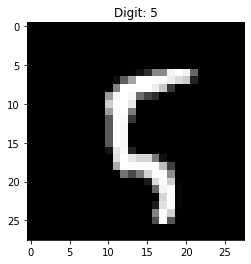

In [31]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Digit: {}'.format(label))

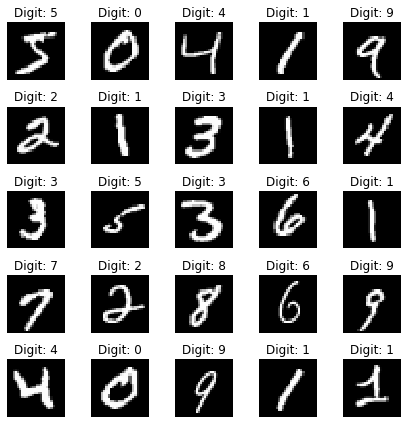

In [32]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6), dpi=150)

for i, ax in enumerate(axs.ravel()):
    image, label = train_set[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('Digit: {}'.format(label))
    ax.axis('off')
    
fig.tight_layout()

In [33]:
image, label = test_set[3]

Text(0.5, 1.0, 'Digit: 1')

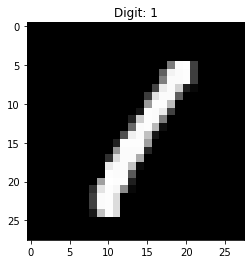

In [34]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Digit: {}'.format(label))

# Building a network for classification

In PyTorch, you define a new neural network by defining a **new class that inherits from nn.Module** as follows:

In [36]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class Network(nn.Module):
    def __init__(self, hidden_size=200):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        x = x.view(-1, 784) # flattens an image of form N x 1 x 28 x 28 -> N x 784
        x = F.relu(self.fc1(x)) # first fully connected layer followed by ReLU
        x = self.fc2(x) # third fully connected layer *without* output ReLU
        x = F.log_softmax(x, dim=1) # make sure that probabilities add up to one, and then take log
        return x

This network was **one hyperparameter - the size of the hidden layer** (defaulting to 200 here)

In [45]:
batch_size = 64 # this is another hyperparameter!
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) # by default shuffle is False

## Training the network

In [47]:
net = Network()
net.train() # puts the network into the training mode

# create and initialize an optimizer
# learning rate is another hyperparameter!
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

start = time.time()
for epoch_idx in range(5):
    for batch_idx, (data, target) in enumerate(training_loader):
        # reset the gradient before the next gradient step
        optimizer.zero_grad()

        # evaluate the network output
        output = net(data)

        # compute the loss
        loss = F.nll_loss(output, target)

        # perform back propagation to compute gradients with respect to parameters!
        loss.backward()

        # perform a gradient descent step on the parameters
        optimizer.step()

        # report the loss every 100 batches
        if batch_idx % 100 == 0:
            print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))
            
duration = time.time() - start
print('Training completed in {:.2f} seconds'.format(duration))

Epoch 0 Loss: 2.288393
Epoch 0 Loss: 1.457423
Epoch 0 Loss: 0.946374
Epoch 0 Loss: 0.810632
Epoch 0 Loss: 0.487209
Epoch 0 Loss: 0.642457
Epoch 0 Loss: 0.815180
Epoch 0 Loss: 0.560318
Epoch 0 Loss: 0.310466
Epoch 0 Loss: 0.333051
Epoch 1 Loss: 0.461971
Epoch 1 Loss: 0.491912
Epoch 1 Loss: 0.496035
Epoch 1 Loss: 0.441014
Epoch 1 Loss: 0.287895
Epoch 1 Loss: 0.345657
Epoch 1 Loss: 0.247349
Epoch 1 Loss: 0.623310
Epoch 1 Loss: 0.389086
Epoch 1 Loss: 0.186830
Epoch 2 Loss: 0.292073
Epoch 2 Loss: 0.504665
Epoch 2 Loss: 0.125850
Epoch 2 Loss: 0.272610
Epoch 2 Loss: 0.176256
Epoch 2 Loss: 0.176656
Epoch 2 Loss: 0.420810
Epoch 2 Loss: 0.344883
Epoch 2 Loss: 0.387879
Epoch 2 Loss: 0.193310
Epoch 3 Loss: 0.430259
Epoch 3 Loss: 0.209964
Epoch 3 Loss: 0.590294
Epoch 3 Loss: 0.342758
Epoch 3 Loss: 0.123374
Epoch 3 Loss: 0.198269
Epoch 3 Loss: 0.326568
Epoch 3 Loss: 0.271248
Epoch 3 Loss: 0.302127
Epoch 3 Loss: 0.109478
Epoch 4 Loss: 0.384009
Epoch 4 Loss: 0.247442
Epoch 4 Loss: 0.237368
Epoch 4 Los

## Evaluating the network

In [60]:
net.eval() # put network into evaluation model
test_loss = 0
correct = 0

# prevents unnecessary gradient computation during test - can lead to time and memory saving
with torch.no_grad(): 
    for data, target in test_loader:
        output = net(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target, reduction='sum').item() 
        
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1] 
        
        # count number of times where max probability matches the label index
        correct += pred.eq(target.view_as(pred)).sum().item()

# divide the test loss by number of samples in the test set
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.2494, Accuracy: 55758/60000 (93%)



Let's look at actual guesses

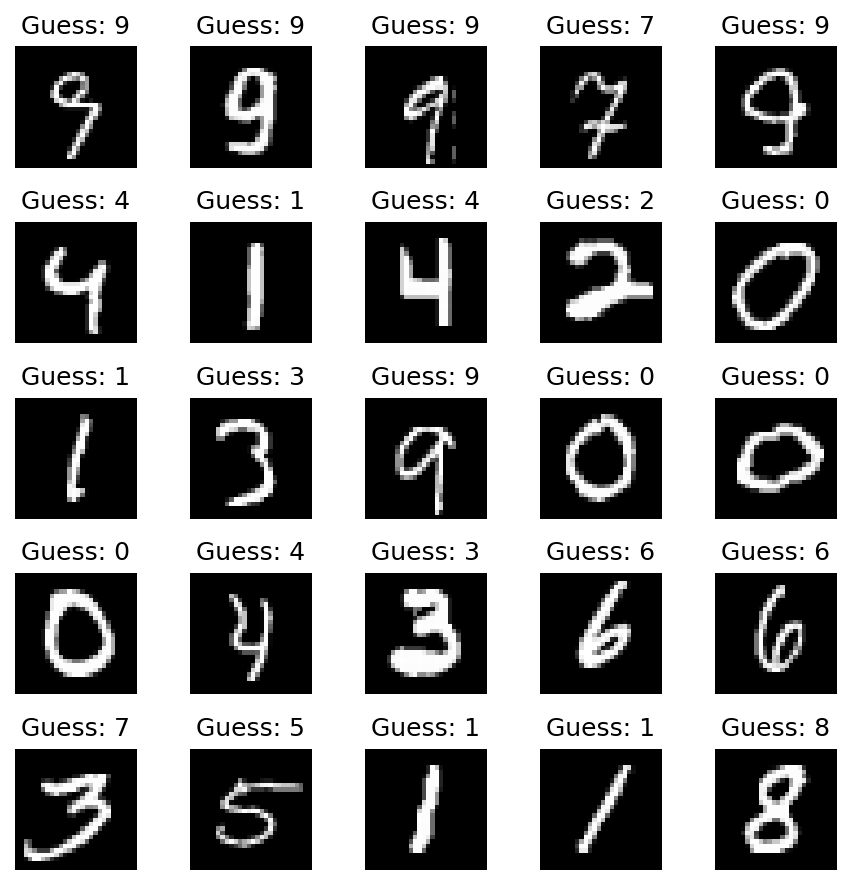

In [73]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6), dpi=150)
image_order = np.random.permutation(len(test_set))
for i, ax in zip(image_order, axs.ravel()):
    image, label = test_set[i]
    p = torch.exp(net(image))
    digit = torch.argmax(p)
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('Guess: {}'.format(digit))
    ax.axis('off')
    
fig.tight_layout()

## Using DataJoint to coordinate the training

Now let's see how we can use DataJoint to streamline this process.

In [74]:
import datajoint as dj

In [71]:
# create a new schema to house tables for network training
schema = dj.schema('network')

In [82]:
@schema
class NetworkConfig(dj.Lookup):
    definition = """
    hidden_size: int    # size of hidden layer
    """
    contents = zip([200])
    
@schema
class TrainingConfig(dj.Lookup):
    definition = """
    train_config_id: int   # unique id for a training config
    ---
    learning_rate: float   # learning rate for SGD
    batch_size: int        # batch_size for training
    n_epochs: int          # number of epochs to train
    """
    contents = [
        (0, 0.005, 64, 5)
    ]
    

@schema
class TrainedNetwork(dj.Computed):
    definition = """
    -> NetworkConfig
    -> TrainingConfig
    ---
    train_duration: float   # duration of training in seconds
    test_loss: float        # loss on the test set
    test_acc: float         # accuracy on the test set
    """
    
    def make(self, key):
        # Get configurations!
        hidden_size = (NetworkConfig & key).fetch1('hidden_size')
        learning_rate, batch_size, n_epochs = (TrainingConfig & key).fetch1('learning_rate',
                                                                            'batch_size',
                                                                            'n_epochs')
        # convert from numpy array into int
        batch_size, n_eochs = int(batch_size), int(n_epochs)
        
        # prepare the data
        image_transform = transforms.Compose([
            transforms.ToTensor(), # converts images into Tensors
            transforms.Normalize([0.1307], [0.3081])
        ])

        # apply the transforms at the time of dataset loading
        train_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                                  transform=image_transform)
        test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                                  transform=image_transform)
        
        # prepare data loaders
        training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) # by default shuffle is False
        
        # instantiate the network
        net = Network(hidden_size=hidden_size)
        net.train() # puts the network into the training mode

        # configure optimizer
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

        start = time.time()
        for epoch_idx in range(n_epochs):
            for batch_idx, (data, target) in enumerate(training_loader):
                # reset the gradient before the next gradient step
                optimizer.zero_grad()

                # evaluate the network output
                output = net(data)

                # compute the loss
                loss = F.nll_loss(output, target)

                # perform back propagation to compute gradients with respect to parameters!
                loss.backward()

                # perform a gradient descent step on the parameters
                optimizer.step()

                # report the loss every 100 batches
                if batch_idx % 100 == 0:
                    print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))

        duration = time.time() - start
        print('Training completed in {:.2f} seconds'.format(duration))
        
        ## Evaluate the network
        net.eval() # put network into evaluation model
        test_loss = 0
        correct = 0

        # prevents unnecessary gradient computation during test - can lead to time and memory saving
        with torch.no_grad(): 
            for data, target in test_loader:
                output = net(data)

                # sum up batch loss
                test_loss += F.nll_loss(output, target, reduction='sum').item() 

                # get the index of the max log-probability
                pred = output.max(1, keepdim=True)[1] 

                # count number of times where max probability matches the label index
                correct += pred.eq(target.view_as(pred)).sum().item()

        # divide the test loss by number of samples in the test set
        test_loss /= len(test_loader.dataset)
        
        # compute accuracy
        accuracy = correct / len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * accuracy))
        
        key['train_duration'] = duration
        key['test_loss'] = test_loss
        key['test_acc'] = accuracy
        
        self.insert1(key)

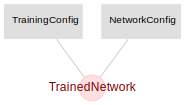

In [83]:
dj.ERD(schema)

In [84]:
TrainingConfig()

train_config_id unique id for a training config,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
0,0.005,64,5


In [85]:
NetworkConfig()

hidden_size size of hidden layer
200


In [86]:
TrainedNetwork.populate()

Epoch 0 Loss: 2.325799
Epoch 0 Loss: 1.480993
Epoch 0 Loss: 0.937624
Epoch 0 Loss: 0.826323
Epoch 0 Loss: 0.641110
Epoch 0 Loss: 0.418894
Epoch 0 Loss: 0.535027
Epoch 0 Loss: 0.477884
Epoch 0 Loss: 0.343144
Epoch 0 Loss: 0.469708
Epoch 1 Loss: 0.311222
Epoch 1 Loss: 0.385419
Epoch 1 Loss: 0.416646
Epoch 1 Loss: 0.263566
Epoch 1 Loss: 0.306561
Epoch 1 Loss: 0.365026
Epoch 1 Loss: 0.379281
Epoch 1 Loss: 0.316105
Epoch 1 Loss: 0.186095
Epoch 1 Loss: 0.327896
Epoch 2 Loss: 0.418825
Epoch 2 Loss: 0.364203
Epoch 2 Loss: 0.230916
Epoch 2 Loss: 0.269981
Epoch 2 Loss: 0.472535
Epoch 2 Loss: 0.220618
Epoch 2 Loss: 0.453983
Epoch 2 Loss: 0.408371
Epoch 2 Loss: 0.435571
Epoch 2 Loss: 0.313577
Epoch 3 Loss: 0.263340
Epoch 3 Loss: 0.274232
Epoch 3 Loss: 0.456796
Epoch 3 Loss: 0.214477
Epoch 3 Loss: 0.185200
Epoch 3 Loss: 0.266357
Epoch 3 Loss: 0.232145
Epoch 3 Loss: 0.241398
Epoch 3 Loss: 0.327115
Epoch 3 Loss: 0.253502
Epoch 4 Loss: 0.305298
Epoch 4 Loss: 0.400427
Epoch 4 Loss: 0.229278
Epoch 4 Los

In [87]:
TrainedNetwork()

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set
200,0,47.5459,0.242517,0.931433


In [89]:
NetworkConfig().insert1((50, ))

In [90]:
NetworkConfig()

hidden_size size of hidden layer
50
200


In [92]:
TrainingConfig.insert1([1, 0.005, 32, 2])

In [93]:
TrainingConfig()

train_config_id unique id for a training config,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
0,0.005,64,5
1,0.005,32,2


In [94]:
TrainedNetwork.populate(display_progress=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Loss: 2.361421
Epoch 0 Loss: 1.708965
Epoch 0 Loss: 1.093079
Epoch 0 Loss: 0.773351
Epoch 0 Loss: 0.702176
Epoch 0 Loss: 0.527673
Epoch 0 Loss: 0.499718
Epoch 0 Loss: 0.533485
Epoch 0 Loss: 0.538753
Epoch 0 Loss: 0.308771
Epoch 1 Loss: 0.401793
Epoch 1 Loss: 0.452481
Epoch 1 Loss: 0.388980
Epoch 1 Loss: 0.311684
Epoch 1 Loss: 0.357906
Epoch 1 Loss: 0.440868
Epoch 1 Loss: 0.407709
Epoch 1 Loss: 0.245921
Epoch 1 Loss: 0.395861
Epoch 1 Loss: 0.276961
Epoch 2 Loss: 0.290190
Epoch 2 Loss: 0.219521
Epoch 2 Loss: 0.257354
Epoch 2 Loss: 0.393640
Epoch 2 Loss: 0.257438
Epoch 2 Loss: 0.223838
Epoch 2 Loss: 0.219138
Epoch 2 Loss: 0.222704
Epoch 2 Loss: 0.234850
Epoch 2 Loss: 0.375260
Epoch 3 Loss: 0.513758
Epoch 3 Loss: 0.197786
Epoch 3 Loss: 0.376619
Epoch 3 Loss: 0.107752
Epoch 3 Loss: 0.130921
Epoch 3 Loss: 0.239116
Epoch 3 Loss: 0.375821
Epoch 3 Loss: 0.355242
Epoch 3 Loss: 0.328055
Epoch 3 Loss: 0.334857
Epoch 4 Loss: 0.423396
Epoch 4 Loss: 0.303567
Epoch 4 Loss: 0.260245
Epoch 4 Los

 33%|███▎      | 1/3 [00:51<01:42, 51.32s/it]


Test set: Average loss: 0.2654, Accuracy: 55452/60000 (92%)

Epoch 0 Loss: 2.283156
Epoch 0 Loss: 1.696761
Epoch 0 Loss: 1.231082
Epoch 0 Loss: 0.800465
Epoch 0 Loss: 0.527165
Epoch 0 Loss: 0.392920
Epoch 0 Loss: 0.481991
Epoch 0 Loss: 0.386935
Epoch 0 Loss: 0.409469
Epoch 0 Loss: 0.202444
Epoch 0 Loss: 0.318296
Epoch 0 Loss: 0.218089
Epoch 0 Loss: 0.437385
Epoch 0 Loss: 0.439002
Epoch 0 Loss: 0.257002
Epoch 0 Loss: 0.581111
Epoch 0 Loss: 0.350299
Epoch 0 Loss: 0.394310
Epoch 0 Loss: 0.275887
Epoch 1 Loss: 0.233756
Epoch 1 Loss: 0.564918
Epoch 1 Loss: 0.561478
Epoch 1 Loss: 0.718147
Epoch 1 Loss: 0.375927
Epoch 1 Loss: 0.427695
Epoch 1 Loss: 0.486127
Epoch 1 Loss: 0.369844
Epoch 1 Loss: 0.379242
Epoch 1 Loss: 0.299523
Epoch 1 Loss: 0.291159
Epoch 1 Loss: 0.117984
Epoch 1 Loss: 0.258686
Epoch 1 Loss: 0.335343
Epoch 1 Loss: 0.301358
Epoch 1 Loss: 0.176353
Epoch 1 Loss: 0.167010
Epoch 1 Loss: 0.357681
Epoch 1 Loss: 0.240905
Training completed in 21.23 seconds


 67%|██████▋   | 2/3 [01:35<00:49, 49.18s/it]


Test set: Average loss: 0.2733, Accuracy: 55312/60000 (92%)

Epoch 0 Loss: 2.296576
Epoch 0 Loss: 1.546451
Epoch 0 Loss: 0.978842
Epoch 0 Loss: 0.837824
Epoch 0 Loss: 0.425134
Epoch 0 Loss: 0.580823
Epoch 0 Loss: 0.316645
Epoch 0 Loss: 0.704896
Epoch 0 Loss: 0.517688
Epoch 0 Loss: 0.304584
Epoch 0 Loss: 0.253898
Epoch 0 Loss: 0.518798
Epoch 0 Loss: 0.254118
Epoch 0 Loss: 0.279804
Epoch 0 Loss: 0.431836
Epoch 0 Loss: 0.230385
Epoch 0 Loss: 0.374613
Epoch 0 Loss: 0.321177
Epoch 0 Loss: 0.432370
Epoch 1 Loss: 0.274258
Epoch 1 Loss: 0.106979
Epoch 1 Loss: 0.456304
Epoch 1 Loss: 0.165679
Epoch 1 Loss: 0.263234
Epoch 1 Loss: 0.292385
Epoch 1 Loss: 0.261012
Epoch 1 Loss: 0.491086
Epoch 1 Loss: 0.222721
Epoch 1 Loss: 0.105356
Epoch 1 Loss: 0.302508
Epoch 1 Loss: 0.364668
Epoch 1 Loss: 0.779309
Epoch 1 Loss: 0.453632
Epoch 1 Loss: 0.083956
Epoch 1 Loss: 0.061269
Epoch 1 Loss: 0.564738
Epoch 1 Loss: 0.100209
Epoch 1 Loss: 0.124760
Training completed in 41.99 seconds


100%|██████████| 3/3 [02:33<00:00, 51.87s/it]


Test set: Average loss: 0.2644, Accuracy: 55472/60000 (92%)



In [95]:
TrainedNetwork()

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set
50,0,43.3886,0.265381,0.9242
50,1,21.2322,0.273329,0.921867
200,0,47.5459,0.242517,0.931433
200,1,41.9885,0.264403,0.924533


In [96]:
TrainedNetwork * TrainingConfig

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
50,0,43.3886,0.265381,0.9242,0.005,64,5
200,0,47.5459,0.242517,0.931433,0.005,64,5
50,1,21.2322,0.273329,0.921867,0.005,32,2
200,1,41.9885,0.264403,0.924533,0.005,32,2
